# Imports

In [1]:
import sys
sys.path.append('../src')

from data_manager import (
    read_frame, annotations_for_frame,
    round_to_power_of_two,
    bounding_boxes_to_mask,
    run_length_encoding
)
from window_manager import slide_window, draw_boxes
from feature_manager import feature_extraction

import os
import math

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pickle
from tqdm import tqdm

import cv2
from skimage import io, color

data_path = '../data'

# Vehicle recognition dataset

In [2]:
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')

H, W, C = 720, 1280, 3
N = 2020

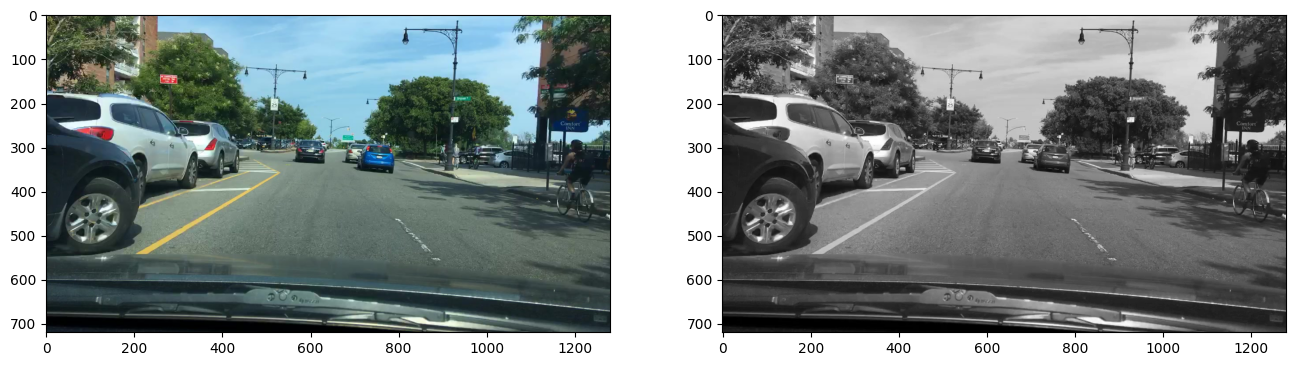

In [3]:
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
frame = read_frame(data_path, train_df, 0)
gray_frame = (color.rgb2gray(frame)*255).astype(np.uint8)

plt.figure(figsize=(16,9))

plt.subplot(1, 2, 1)
plt.imshow(frame)

plt.subplot(1, 2, 2)
plt.imshow(gray_frame, cmap='gray')

plt.show()

# Check interesting window sizes

In [4]:
interesting_windows = []

for line in tqdm(range(len(train_df))):
    rectangles = annotations_for_frame(train_df, line)
    for _, _, dx, dy in rectangles: 
        interesting_windows.append((round_to_power_of_two(dx), round_to_power_of_two(dy)))

len(interesting_windows)

  0%|          | 0/2020 [00:00<?, ?it/s]

100%|██████████| 2020/2020 [00:00<00:00, 2712.57it/s]


16018

In [5]:
size_dic = {}

for i in range(1, 11):
    for j in range(1, 11):
        size_dic[(2**i, 2**j)] = interesting_windows.count((2**i, 2**j))

sorted_dic = dict(sorted(size_dic.items(), key=lambda item: item[1], reverse=True))
print(len(sorted_dic))
print(sorted_dic)
print(sum(sorted_dic.values()))

first_values_sum = sum(value for key, value in list(sorted_dic.items())[:5])
print(first_values_sum/len(interesting_windows))

INTERESTING_WINDOWS = list(sorted_dic.keys())[:5]

100
{(32, 32): 2695, (64, 64): 2043, (64, 32): 1763, (128, 64): 1383, (32, 16): 1197, (16, 16): 1045, (128, 128): 1004, (256, 256): 839, (256, 128): 826, (16, 32): 587, (32, 64): 470, (64, 16): 332, (16, 8): 238, (512, 256): 211, (32, 8): 210, (128, 32): 173, (64, 128): 149, (512, 512): 105, (8, 16): 97, (256, 64): 92, (16, 64): 81, (128, 256): 74, (8, 32): 71, (256, 512): 52, (8, 8): 49, (4, 32): 44, (64, 8): 37, (32, 128): 27, (64, 256): 19, (512, 128): 19, (16, 4): 18, (32, 4): 16, (16, 128): 12, (8, 64): 10, (128, 16): 8, (4, 16): 7, (128, 512): 5, (32, 256): 3, (256, 32): 2, (8, 4): 1, (8, 128): 1, (16, 2): 1, (64, 4): 1, (1024, 128): 1, (2, 2): 0, (2, 4): 0, (2, 8): 0, (2, 16): 0, (2, 32): 0, (2, 64): 0, (2, 128): 0, (2, 256): 0, (2, 512): 0, (2, 1024): 0, (4, 2): 0, (4, 4): 0, (4, 8): 0, (4, 64): 0, (4, 128): 0, (4, 256): 0, (4, 512): 0, (4, 1024): 0, (8, 2): 0, (8, 256): 0, (8, 512): 0, (8, 1024): 0, (16, 256): 0, (16, 512): 0, (16, 1024): 0, (32, 2): 0, (32, 512): 0, (32, 1024

# Search window

In [ ]:
# For method with extracted dataset

with open('models/classification_dataset_from_recognition_dataset_scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

with open('models/classification_dataset_from_recognition_dataset_classifier.pkl', 'rb') as file:
    classifier = pickle.load(file)


In [6]:
# For method with external dataset

with open('models/external_classification_dataset_scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

with open('models/external_classification_dataset_classifier.pkl', 'rb') as file:
    classifier = pickle.load(file)

In [7]:
slide_window_params = {
    'x_start_stop': [None, None],
    'y_start_stop': [200, 550],
    'window_sizes': INTERESTING_WINDOWS + [(512, 512)] + [(256, 512)],
    'overlapping': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
}
print(slide_window_params['window_sizes'] )

[(32, 32), (64, 64), (64, 32), (128, 64), (32, 16), (512, 512), (256, 512)]


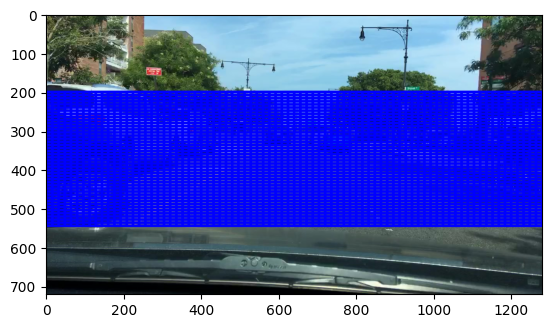

In [8]:
feature_image = frame
windows = slide_window(feature_image, **slide_window_params)              
window_img = draw_boxes(feature_image, windows, color=(0, 0, 255), thick=6)  
plt.imshow(window_img)
plt.show()

[(32, 32), (64, 64), (128, 128), (256, 256)]


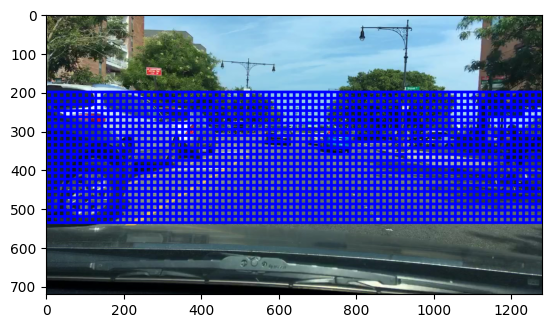

2016

In [9]:
# slide_window_params['window_sizes'] = \
#     [(32, 32), (64, 64), (128, 128), (256, 256), (512, 512)] + \
#     [(32, 16), (64, 32), (128, 64), (256, 128)] + \
#     [(256, 512)]
# slide_window_params['overlapping'] = \
#     [0.25, 0.25, 0.25, 0.25, 0.25] + \
#     [0.25, 0.25, 0.25, 0.25] + \
#     [0.25]

# slide_window_params['window_sizes'] = [(64,64), (128, 128), (256, 256), (512, 512)]
# slide_window_params['overlapping'] = [0.5, 0.5, 0.5, 0.5]

slide_window_params = {
    'x_start_stop': [None, None],
    'y_start_stop': [200, 550],
    'window_sizes': [(32,32), (64,64), (128, 128), (256, 256)],
    'overlapping': [0.5, 0.5, 0.5, 0.5]
}

print(slide_window_params['window_sizes'])

feature_image = frame
windows = slide_window(feature_image, **slide_window_params)              
window_img = draw_boxes(feature_image, windows, color=(0, 0, 255), thick=6)  
plt.imshow(window_img)
plt.show()

len(windows)

In [ ]:
# For method with extracted dataset

slide_window_params = {
    'x_start_stop': [None, None],
    'y_start_stop': [200, 550],
    'window_sizes': [(32,32), (64,64), (128, 128), (256, 256)],
    'overlapping': [0.5, 0.5, 0.5, 0.5]
}
spatial_bin_params = {
    'spatial_size': (32,32)
}
color_hist_params = {
    'color_bins_n': 32,
    'color_bins_range': (0,256)
}
hog_hist_params = {
    'channel_axis': 2,
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'transform_sqrt': True
}

from skimage import transform

def search_windows(
    img, windows, 
    scaler, classifier, 
    spatial_size, 
    color_bins_n, color_bins_range, 
    orientations, pixels_per_cell, cells_per_block, transform_sqrt, channel_axis,
    resize=(64,64)
):

    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    count = 0

    for window in windows:
        count += 1

        # Extract the test window from original image
        test_img = transform.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], resize)

        # Extract features for that window using single_img_features()
        features = feature_extraction(
            test_img, 
            spatial_size,
            color_bins_n, color_bins_range,
            orientations, pixels_per_cell, cells_per_block, transform_sqrt, channel_axis
        )

        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))

        # Predict using your classifier
        prediction = classifier.predict(test_features)

        if prediction == 1 and not any(
            all(
                [win[0][0] <= window[0][0], win[0][1] <= window[0][1],
                 win[1][0] >= window[1][0], win[1][1] >= window[1][1]]
            ) for win in on_windows
        ):
            on_windows.append(window)

    return on_windows

vehicle_windows = search_windows(
    frame, windows,
    scaler, classifier, 
    **spatial_bin_params,
    **color_hist_params,
    **hog_hist_params
)
frame_with_recognition = draw_boxes(frame, vehicle_windows, color=(0, 0, 255), thick=6)  
plt.imshow(frame_with_recognition)
plt.show()

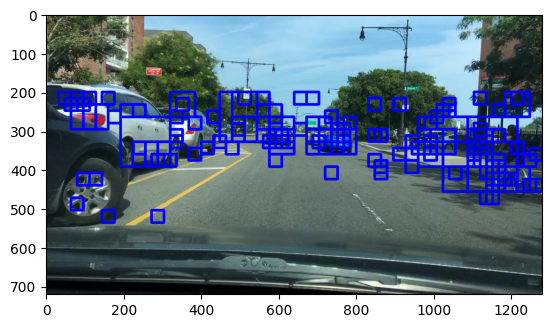

In [10]:
# For method with external dataset

slide_window_params = {
    'x_start_stop': [None, None],
    'y_start_stop': [200, 550],
    'window_sizes': [(32,32), (64,64), (128, 128), (256, 256)],
    'overlapping': [0.5, 0.5, 0.5, 0.5]
}
spatial_bin_params = {
    'spatial_size': (32,32)
}
color_hist_params = {
    'color_bins_n': 32,
    'color_bins_range': (0,256)
}
hog_hist_params = {
    'channel_axis': None,
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'transform_sqrt': True
}

from feature_manager import spatial_bin, hog_hist

def feature_extraction(
    image, 
    spatial_size,
    color_bins_n, color_bins_range,
    orientations, pixels_per_cell, cells_per_block, transform_sqrt,
    channel_axis=None
):
    
    features = []

    spatial_features = spatial_bin(
        image, 
        size=spatial_size
    )
    features.append(spatial_features)

    # color_features = color_hist(
    #     image, 
    #     nbins=color_bins_n, bins_range=color_bins_range
    # )
    # features.append(color_features)

    if channel_axis is not None:
        for channel in range(image.shape[channel_axis]):
            hog_features = hog_hist(
                image[:,:,channel],
                orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
                transform_sqrt=transform_sqrt
            )
            features.append(hog_features)
    else:
        hog_features = hog_hist(
                image,
                orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
                transform_sqrt=transform_sqrt
            )
        features.append(hog_features)

    return np.concatenate(features)

from skimage import io , color, transform

def search_windows(
    img, windows, 
    scaler, classifier, 
    spatial_size, 
    color_bins_n, color_bins_range, 
    orientations, pixels_per_cell, cells_per_block, transform_sqrt, channel_axis,
    resize=(64,64)
):

    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    count = 0

    for window in windows:
        count += 1

        # Extract the test window from original image
        test_img = transform.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], resize)
        test_img = color.rgb2gray(test_img)

        # Extract features for that window using single_img_features()
        features = feature_extraction(
            test_img, 
            spatial_size,
            color_bins_n, color_bins_range,
            orientations, pixels_per_cell, cells_per_block, transform_sqrt, channel_axis
        )

        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))

        # Predict using your classifier
        prediction = classifier.predict(test_features)

        if prediction == 1 and not any(
            all(
                [win[0][0] <= window[0][0], win[0][1] <= window[0][1],
                 win[1][0] >= window[1][0], win[1][1] >= window[1][1]]
            ) for win in on_windows
        ):
            on_windows.append(window)

    return on_windows


vehicle_windows = search_windows(
    frame, windows,
    scaler, classifier, 
    **spatial_bin_params,
    **color_hist_params,
    **hog_hist_params
)
frame_with_recognition = draw_boxes(frame, vehicle_windows, color=(0, 0, 255), thick=6)  
plt.imshow(frame_with_recognition)
plt.show()

# Heatmap

In [11]:
from scipy.ndimage import label

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        boxes.append(bbox)
    # Return the image
    return img, boxes

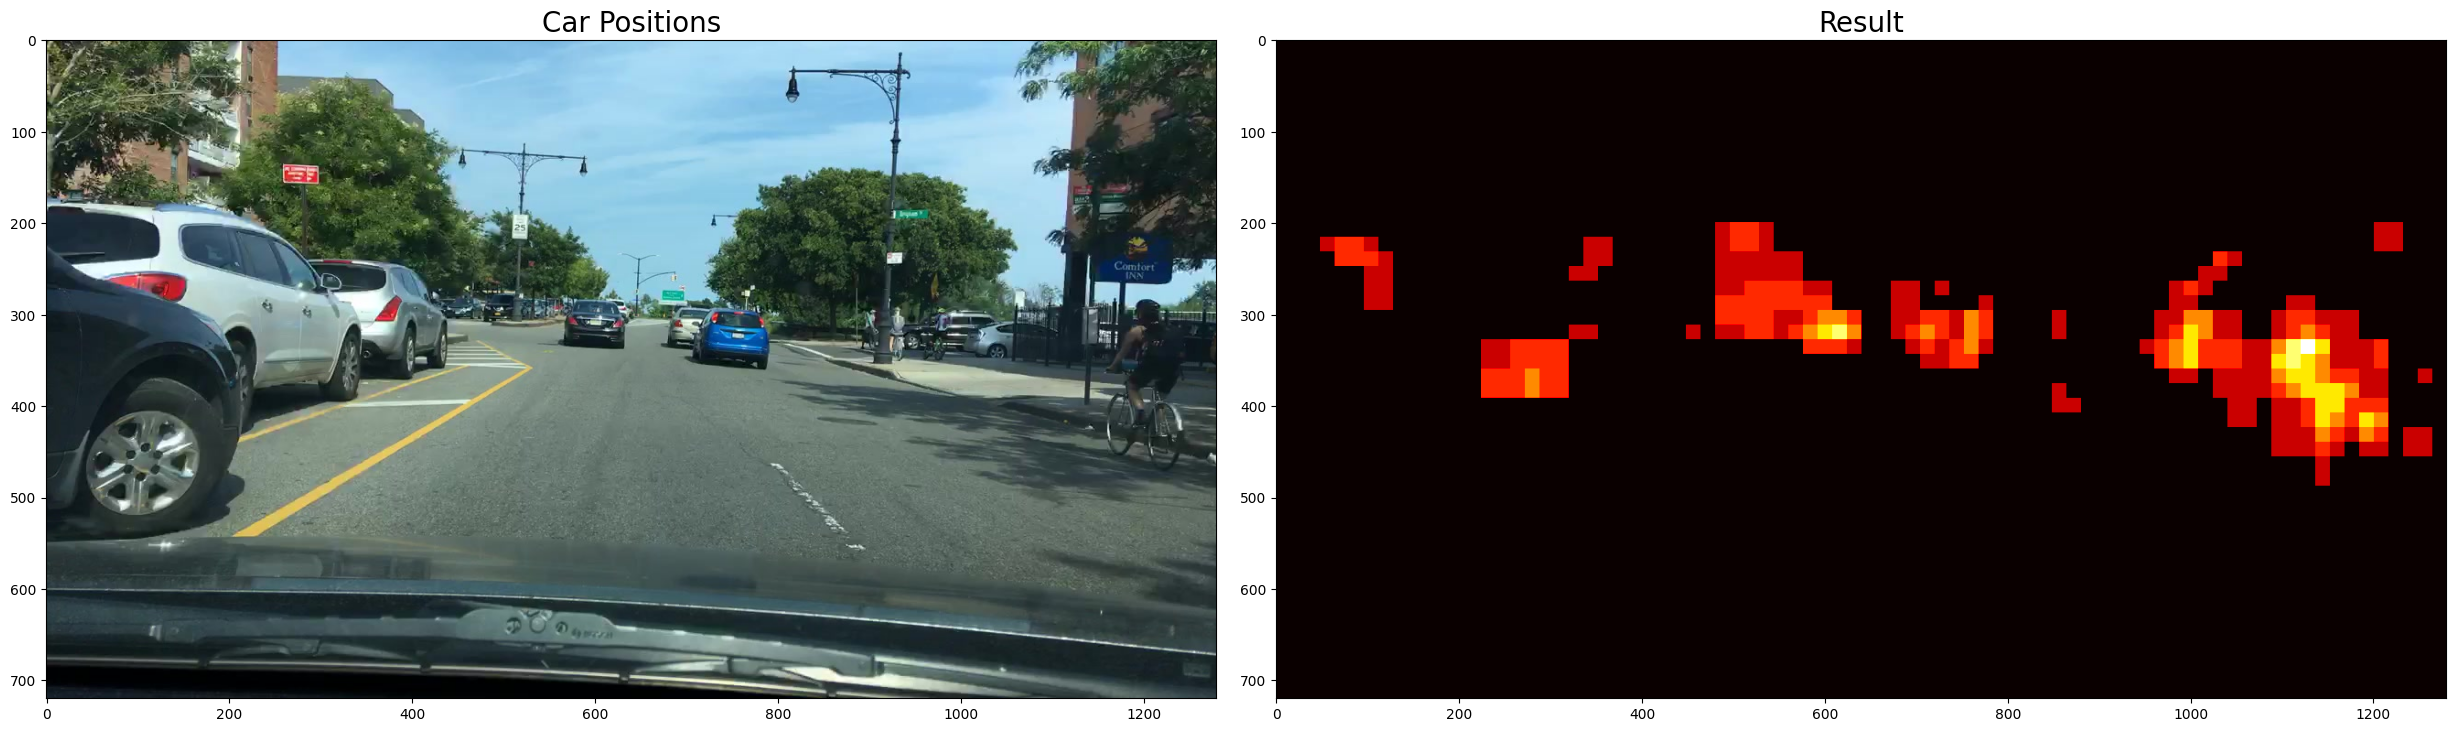

In [13]:
heat = np.zeros_like(frame[:,:,0]).astype(np.float32)
heat = add_heat(heat, vehicle_windows)

# Apply threshold to help remove false positives
threshold = 1
heat = apply_threshold(heat, threshold)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(frame), labels)

def show_images(image1, image2,  image1_exp="Image 1", image2_exp="Image 2"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_exp, fontsize=20)
    ax2.imshow(image2, cmap='hot')
    ax2.set_title(image2_exp, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

show_images(frame, heatmap, "Car Positions", "Result")

In [14]:
draw_img[0].shape
draw_img[1]

[((480, 200), (639, 343)),
 ((1200, 200), (1231, 231)),
 ((48, 216), (127, 295)),
 ((320, 216), (367, 263)),
 ((944, 232), (1215, 487)),
 ((672, 264), (783, 359)),
 ((720, 264), (735, 279)),
 ((848, 296), (863, 327)),
 ((320, 312), (351, 327)),
 ((448, 312), (463, 327)),
 ((224, 328), (319, 391)),
 ((1248, 360), (1263, 375)),
 ((848, 376), (879, 407)),
 ((1232, 424), (1263, 455))]

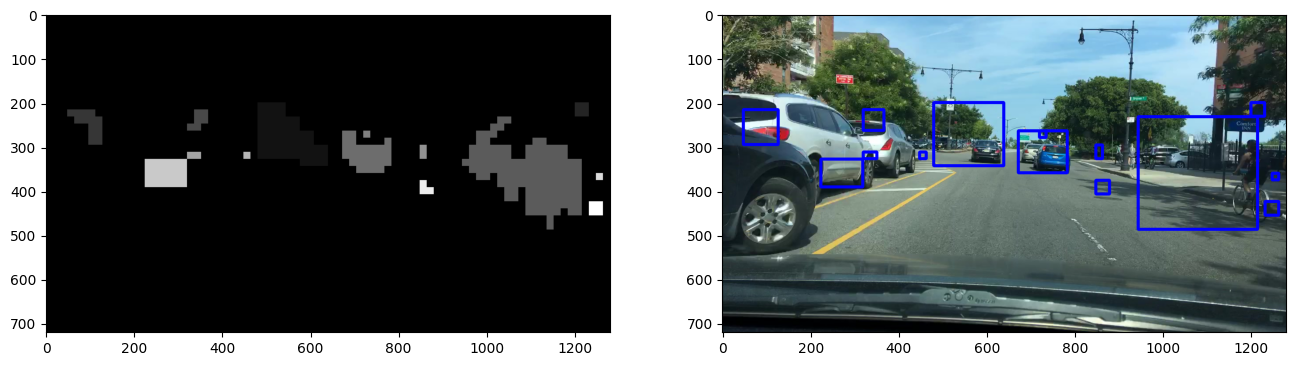

In [15]:
plt.figure(figsize=(16,9))
plt.subplot(1,2,1)
plt.imshow(labels[0], cmap='gray')

plt.subplot(1,2,2)
plt.imshow(draw_img[0])

plt.show()

# Recognition

In [34]:
# For method with extracted dataset

slide_window_params = {
    'x_start_stop': [None, None],
    'y_start_stop': [200, 550],
    'window_sizes': [(32,32), (64,64), (128, 128), (256, 256)],
    'overlapping': [0.5, 0.5, 0.5, 0.5]
}
spatial_bin_params = {
    'spatial_size': (32,32)
}
color_hist_params = {
    'color_bins_n': 32,
    'color_bins_range': (0,256)
}
hog_hist_params = {
    'channel_axis': 2,
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'transform_sqrt': True
}
heat_threshold = 1

with open('models/classification_dataset_from_recognition_dataset_scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

with open('models/classification_dataset_from_recognition_dataset_classifier.pkl', 'rb') as file:
    classifier = pickle.load(file)

NAME_OF_OUTPUT_FILE = 'outputs/with_classification_dataset_from_recognition_dataset.csv'

In [16]:
# For method with external dataset

slide_window_params = {
    'x_start_stop': [None, None],
    'y_start_stop': [200, 550],
    'window_sizes': [(32,32), (64,64), (128, 128), (256, 256)],
    'overlapping': [0.5, 0.5, 0.5, 0.5]
}
spatial_bin_params = {
    'spatial_size': (32,32)
}
color_hist_params = {
    'color_bins_n': 32,
    'color_bins_range': (0,256)
}
hog_hist_params = {
    'channel_axis': None,
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'transform_sqrt': True
}
heat_threshold = 1

with open('models/external_classification_dataset_scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

with open('models/external_classification_dataset_classifier.pkl', 'rb') as file:
    classifier = pickle.load(file)

NAME_OF_OUTPUT_FILE = 'outputs/with_classification_dataset_from_external_dataset.csv'

In [17]:
test_files = sorted(os.listdir(test_data_path), key=lambda x: int(x.split('.')[0]))
test_files[:2]

['1.jpg', '2.jpg']

In [18]:
def bounding_boxes_to_mask(bounding_boxes, H, W):
    
    """
    Converts set of bounding boxes to a binary mask
    """

    mask = np.zeros((H, W))
    for (x, y), (dx, dy) in bounding_boxes:
        mask[y:y+dy, x:x+dx] = 1

    return mask

In [19]:
rows = [] 
   
for file_name in tqdm(test_files):

    # Get image
    test_image = io.imread(os.path.join(test_data_path, file_name)) 

    # Get windows
    windows = slide_window(test_image, **slide_window_params)    
      
    # Detects cars in the windows
    windows_with_cars = search_windows(
        test_image, windows,
        scaler, classifier, 
        **spatial_bin_params,
        **color_hist_params,
        **hog_hist_params
    ) 
    # Heatmap
    heat = np.zeros_like(test_image[:,:,0]).astype(np.float32)
    heat = add_heat(heat, windows_with_cars)
    heat = apply_threshold(heat, heat_threshold)
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img, boxes = draw_labeled_bboxes(np.copy(frame), labels)
    
    # encode the bounding boxes detected for the frame
    rle = run_length_encoding(bounding_boxes_to_mask(boxes, H, W))

    #append the predicted bounding boxes to your results' list
    rows.append(['test/' + file_name, rle])

# generate csv submission
df_prediction = pd.DataFrame(columns=['Id', 'Predicted'], data=rows).set_index('Id')
df_prediction.to_csv(NAME_OF_OUTPUT_FILE)

100%|██████████| 202/202 [40:27<00:00, 12.02s/it]
